# Imports

In [1]:
import logging
import os
from pathlib import Path
import geopandas as gpd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
from imageio import imread

from multiview_mapping_toolkit.segmentation import (
    write_chips,
    assemble_tiled_predictions,
)
from multiview_mapping_toolkit.utils.prediction_metrics import plot_geodata
from multiview_mapping_toolkit.utils.geospatial import get_overlap_raster
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define constants 

In [2]:
INFERENCE_SITE = "chips"
training_sites = ["delta", "valley"] # TODO change this

In [3]:
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"


IDs_TO_LABELS = {
    0: "ABCO",
    1: "CADE",
    2: "PILA",
    3: "PIPO",
    4: "PSME",
    5: "QUEV",
    6: "SNAG",
    7: "ground",
}
TRAINING_SITES_STR = "_".join(training_sites)

# Project root
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
# Input files
VECTOR_LABEL_FILENAME = Path(
    PROJECT_ROOT, "field_ref", "crowns_drone_w_field_data.geojson"
)
LABEL_COLUMN = "species_observed"
INFERENCE_RASTER_FILENAME = Path(
    PROJECT_ROOT,
    "per_site_processing",
    INFERENCE_SITE,
    "02_photogrammetry",
    "exports",
    "orthos",
    f"{INFERENCE_SITE}.tif",
)

BATCH_SIZE = 2
CHIP_SIZE = 3648
INFERENCE_STRIDE = int(CHIP_SIZE / 2)
INFERENCE_IMGS_EXT = ".png"

INFERENCE_CHIPS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    INFERENCE_SITE,
    "04_model_preds",
    "ortho_chipped_images",
)
PREDICTIONS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    INFERENCE_SITE,
    "04_model_preds",
    "ortho_chipped_images_preds",
)
TRAINING_DATA_FOLDER = Path(
    PROJECT_ROOT,
    "models",
    "multi_site",
    f"ortho_{TRAINING_SITES_STR}",
)

AGGREGATED_LABELS_FOLDER = Path(TRAINING_DATA_FOLDER, "inputs", "labels")
WORK_DIR = Path(TRAINING_DATA_FOLDER, "work_dir")
AGGREGATED_RASTER_PRED = Path(
    PROJECT_ROOT,
    "per_site_processing",
    INFERENCE_SITE,
    "05_processed_predictions",
    f"{TRAINING_SITES_STR}_model_ortho_pred.tif",
)

In [4]:
logging.basicConfig(level="INFO")

<Axes: >

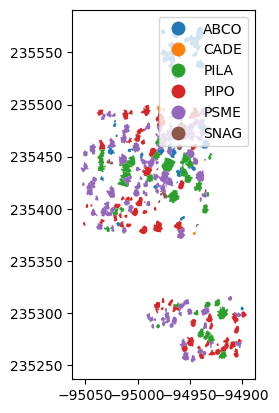

In [5]:
# Load the data
gdf = gpd.read_file(VECTOR_LABEL_FILENAME)

gdf.query(f"fire=='{INFERENCE_SITE}'").plot(LABEL_COLUMN, legend=True, vmin=0, vmax=9)

# Create training chips

In [6]:
write_chips(
    raster_file=INFERENCE_RASTER_FILENAME,
    output_folder=INFERENCE_CHIPS_FOLDER,
    chip_size=CHIP_SIZE,
    chip_stride=INFERENCE_STRIDE,
    output_suffix=INFERENCE_IMGS_EXT,
    ROI_file=VECTOR_LABEL_FILENAME,
)

Writing image chips to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images: 100%|██████████| 972/972 [01:17<00:00, 12.47it/s] 


/tmp/ipykernel_48344/1830533264.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(file))


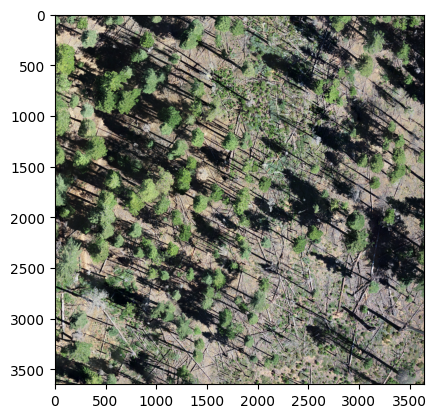

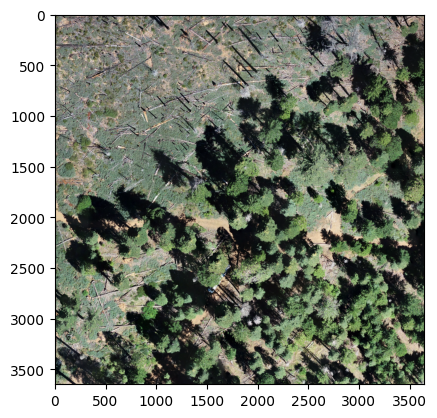

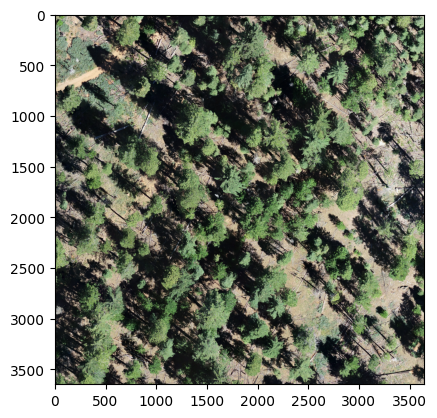

In [7]:
files = list(INFERENCE_CHIPS_FOLDER.glob("*" + INFERENCE_IMGS_EXT))
np.random.shuffle(files)
for file in files[:3]:
    plt.imshow(imread(file))
    plt.show()

In [8]:
config_file = list(Path(WORK_DIR).glob("*py"))[0]
checkpoint_file = Path(WORK_DIR, "iter_10000.pth")

subprocess.run(
    f"{MMSEG_PYTHON} {INFERENCE_SCRIPT} {config_file} {checkpoint_file} {INFERENCE_CHIPS_FOLDER} {PREDICTIONS_FOLDER} --batch-size {BATCH_SIZE}",
    shell=True,
)

/ofo-share/repos-david/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Traceback (most recent call last):
  File "/ofo-share/repos-david/mmsegmentation/tools/inference.py", line 41, in <module>
    model = init_model(str(args.config_path), str(args.checkpoint_path))
  File "/ofo-share/repos-david/mmsegmentation/mmseg/apis/inference.py", line 59, in init_model
    checkpoint = load_checkpoint(model, checkpoint, map_location="cpu")
  File "/ofo-share/repos-david/conda/envs/openmmlab/lib/python3.8/site-packages/mmengine/runner/checkpoint.py", line 636, in load_c

Loads checkpoint by local backend from path: /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/ortho_delta_valley/work_dir/iter_10000.pth


CompletedProcess(args='/ofo-share/repos-david/conda/envs/openmmlab/bin/python /ofo-share/repos-david/mmsegmentation/tools/inference.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/ortho_delta_valley/work_dir/ortho_delta_valley.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/ortho_delta_valley/work_dir/iter_10000.pth /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds --batch-size 2', returncode=1)

In [9]:
# Add _vis to the folder name. Can't just add _vis to the str representation because it might have a trailing slash
pred_vis_dir = Path(
    Path(PREDICTIONS_FOLDER).parent, Path(PREDICTIONS_FOLDER).parts[-1] + "_vis"
)
STRIDE = 5

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {VIS_PREDS_SCRIPT} --image-dir {INFERENCE_CHIPS_FOLDER} "
    + f"--seg-dir {PREDICTIONS_FOLDER} --output-dir {pred_vis_dir} --stride {STRIDE}",
    shell=True,
)

visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis: 100%|██████████| 6/6 [01:25<00:00, 14.33s/it]


CompletedProcess(args='/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py --image-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images --seg-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds --output-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis --stride 5', returncode=0)

/tmp/ipykernel_48344/88537265.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(file))


/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis/chips:23712:9120:3648:3648.png


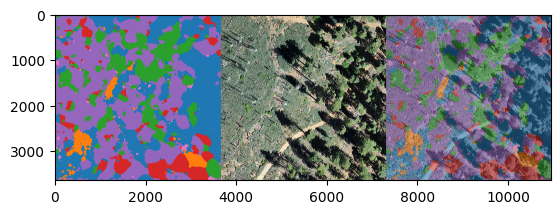

/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis/chips:29184:14592:3648:3648.png


FileNotFoundError: No such file: '/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis/chips:29184:14592:3648:3648.png'

In [10]:
files = list(pred_vis_dir.glob("*"))
np.random.shuffle(files)
for file in files[:3]:
    print(file)
    plt.imshow(imread(file))
    plt.show()

In [ ]:
pred_files = list(PREDICTIONS_FOLDER.glob("*"))
num_classes = len(IDs_TO_LABELS) - 1  # For the ground class
assemble_tiled_predictions(
    raster_input_file=INFERENCE_RASTER_FILENAME,
    pred_files=pred_files,
    num_classes=num_classes,
    class_savefile=AGGREGATED_RASTER_PRED,
)

Aggregating raster predictions:   0%|          | 0/28 [00:00<?, ?it/s]

Writing out max class: 100%|██████████| 14592/14592 [00:05<00:00, 2613.93it/s]
visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis:  61%|██████    | 17/28 [04:09<02:47, 15.24s/it]

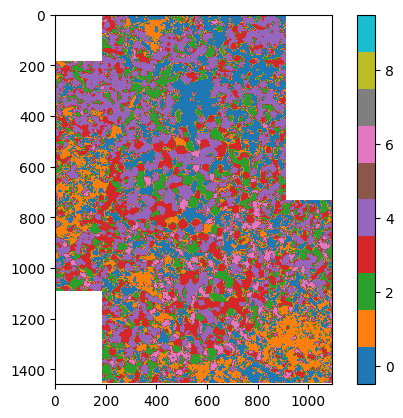

visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis:  64%|██████▍   | 18/28 [04:27<02:39, 15.95s/it]

In [ ]:
_, ax = plt.subplots(1, 1)
plot_geodata(AGGREGATED_RASTER_PRED, ax=ax)

# Assign labels to regions

In [ ]:
class_fractions, IDs_in_original = get_overlap_raster(
    unlabeled_df=VECTOR_LABEL_FILENAME,
    classes_raster=AGGREGATED_RASTER_PRED,
    num_classes=num_classes,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Ground truth
Predicted


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

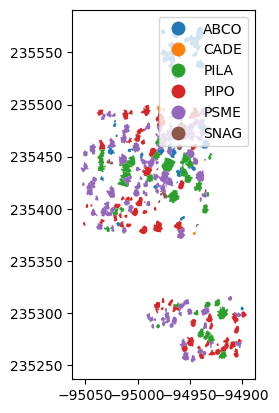

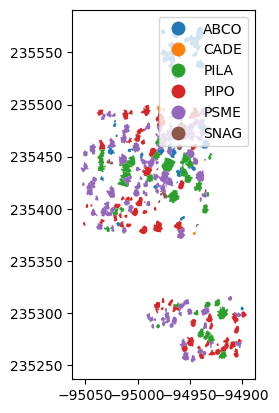

visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis:  68%|██████▊   | 19/28 [04:42<02:20, 15.64s/it]

In [ ]:
pred_IDs = np.argmax(class_fractions, axis=1)
pred_class = [IDs_TO_LABELS[pred_ID] for pred_ID in pred_IDs]

# Load the data
gdf = gpd.read_file(VECTOR_LABEL_FILENAME)
site_gdf = gdf.iloc[IDs_in_original]
site_gdf["pred_class"] = pred_class
print("Ground truth")
site_gdf.plot(LABEL_COLUMN, legend=True, vmin=-0.5, vmax=9.5)
print("Predicted")
site_gdf.plot("pred_class", legend=True, vmin=-0.5, vmax=9.5)

GT classes ['CADE', 'PIPO', 'SNAG', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'ABCO', 'PSME', 'PSME', 'PILA', 'PIPO', 'ABCO', 'PSME', 'PIPO', 'PSME', 'SNAG', 'ABCO', 'PSME', 'PSME', 'PSME', 'SNAG', 'PSME', 'PSME', 'ABCO', 'PSME', 'PIPO', 'PSME', 'PSME', 'PSME', 'PSME', 'PSME', 'ABCO', 'PSME', 'PSME', 'PIPO', 'PSME', 'PSME', 'PSME', 'PIPO', 'PILA', 'PIPO', 'PSME', 'PSME', 'PIPO', 'ABCO', 'ABCO', 'ABCO', 'SNAG', 'PIPO', 'PSME', 'PSME', 'PSME', 'ABCO', 'ABCO', 'PSME', 'ABCO', 'PIPO', 'ABCO', 'PSME', 'PSME', 'PILA', 'ABCO', 'PILA', 'PILA', 'PILA', 'PSME', 'PILA', 'SNAG', 'PILA', 'SNAG', 'PSME', 'PSME', 'PSME', 'PSME', 'SNAG', 'PILA', 'PILA', 'PILA', 'PSME', 'PILA', 'ABCO', 'PSME', 'PIPO', 'ABCO', 'PILA', 'PIPO', 'PILA', 'PSME', 'PSME', 'PSME', 'PILA', 'ABCO', 'PSME', 'PSME', 'PILA', 'PSME', 'PSME', 'ABCO', 'PILA', 'PSME', 'PSME', 'PSME', 'PIPO', 'PSME', 'PSME', 'PSME', 'ABCO', 'PILA', 'PSME', 'PSME', 'PSME', 'SNAG', 'PSME', 'PSME', 'PSME', 'PILA', 'PSME', 'SNAG', 'PSME', 'PILA', 'PSM

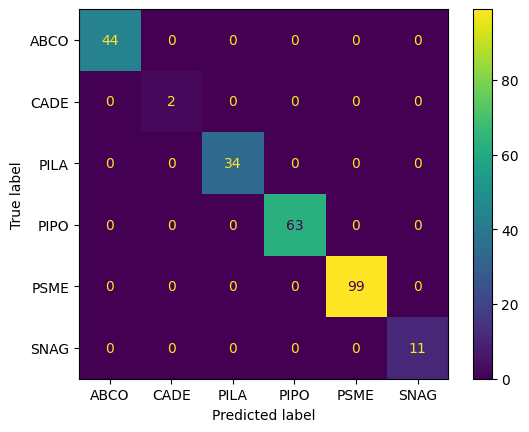

(array([[44,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0,  0],
        [ 0,  0, 34,  0,  0,  0],
        [ 0,  0,  0, 63,  0,  0],
        [ 0,  0,  0,  0, 99,  0],
        [ 0,  0,  0,  0,  0, 11]]),
 array(['ABCO', 'CADE', 'PILA', 'PIPO', 'PSME', 'SNAG'], dtype='<U4'),
 1.0)

visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/04_model_preds/ortho_chipped_images_preds_vis: 100%|██████████| 28/28 [06:50<00:00, 14.66s/it]


In [ ]:
gt_list = site_gdf[LABEL_COLUMN].tolist()
pred_list = site_gdf["pred_class"].tolist()
print(f"GT classes {gt_list}")
print(f"Pred classes {pred_list}")

compute_and_show_cf(pred_labels=pred_list, gt_labels=gt_list)